In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_list <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [3]:
dset_idx <- 2
# hub_con_thresh <- 0.5
hub_con_thresh <- 0.0

In [4]:
text_size <- 11
guide_size <- 1
family <- "arial"
dpi <- 320
ht <- 4
wd <- 5

In [5]:
matrisome_df <- rutils::load_matrisome_df(matrisome_list) %>%
    dplyr::select(gene_symbol, division, category) %>%
    dplyr::rename(geneID = gene_symbol)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)




In [6]:
demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))
umsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_umsmg_list.txt"))
nsmg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_nsmg_hub_thresh_", hub_con_thresh, "_list.txt"))
figo_list <- union(umsmg_list, nsmg_list)

In [7]:
length(demg_list)
length(umsmg_list)
length(nsmg_list)
length(figo_list)
length(intersect(figo_list, demg_list))

[1] 595

[1] 65

[1] 175

[1] 221

[1] 134

In [8]:
matrisome_mem_df <- matrisome_df %>%
    dplyr::mutate(
        de = geneID %in% demg_list,
        predictive = geneID %in% figo_list,
        both = de & predictive
    ) %>%
    dplyr::mutate(membership = case_when(
        de & !both ~ "DE only",
        predictive & !both ~ "FIGO sig. only",
        both == TRUE ~ "FIGO sig. and DE",
        !de & !predictive ~ "Neither"
    )) %>%
    dplyr::mutate(membership = factor(membership, levels = c("FIGO sig. only", "FIGO sig. and DE", "DE only", "Neither")))

In [9]:
matrisome_bp_df <- matrisome_mem_df %>%
    group_by(category, membership) %>%
    summarize(count = n())

`summarise()` has grouped output by 'category'. You can override using the `.groups` argument.



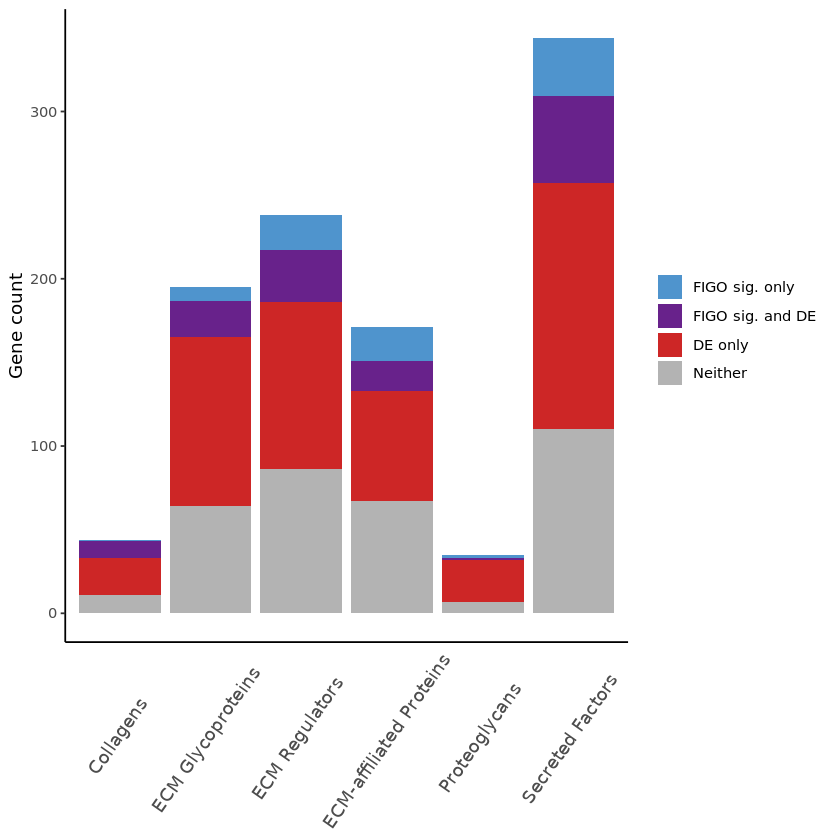

In [10]:
ggplot(data = matrisome_bp_df, aes(x = category, y = count, fill = membership)) +
    geom_bar(stat = "identity") +
    scale_fill_manual(values = c("FIGO sig. only" = "steelblue3", "FIGO sig. and DE" = "darkorchid4", "DE only" = "firebrick3", "Neither" = "gray70")) +
    guides(fill = guide_legend(override.aes = list(size = guide_size))) +
    theme_classic() +
    theme(
        text = element_text(size = text_size, family = family),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_text(size = text_size, angle = 55, vjust = 0.55, hjust=0.55),
        legend.title = element_blank(),
    ) +
    labs(y = "Gene count", fill = "Membership")
ggsave(paste0(dirs$figures_dir, "/deg/", unified_dsets[dset_idx], "_figo_sig_demg_stacked_bp.png"), last_plot(), height = ht, width = wd, dpi = dpi)
